# Summative Assignment: Steel Plate Fault Detection
**Student Name:** Edwin Bayingana

## 1. Problem Definition & Motivation
Quality control of construction materials is critical; defects in structural steel plates (such as scratches or fissures) can severely compromise load-bearing capacities. This project automates fault detection using Machine Learning.

## 2. Methodology
I implement a comparative pipeline between Traditional Machine Learning (Random Forest) and Deep Learning (Neural Networks). I will conduct 16 sequential experiments. After each run, I analyze the Classification Report, Confusion Matrix, and ROC-AUC curves to inform the hyperparameter tuning of the subsequent experiment.

In [1]:
# CELL 1: IMPORTS, PIPELINE, AND HELPERS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from tensorflow.keras import models, layers, regularizers, callbacks

# 1. REPRODUCIBILITY
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 2. DATA PIPELINE
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00198/Faults.NNA"
feature_names = [
    "X_Minimum", "X_Maximum", "Y_Minimum", "Y_Maximum", "Pixels_Areas", "X_Perimeter",
    "Y_Perimeter", "Sum_of_Luminosity", "Minimum_of_Luminosity", "Maximum_of_Luminosity",
    "Length_of_Conveyer", "TypeOfSteel_A300", "TypeOfSteel_A400", "Steel_Plate_Thickness",
    "Edges_Index", "Empty_Index", "Square_Index", "Outside_X_Index", "Edges_X_Index",
    "Edges_Y_Index", "Outside_Global_Index", "LogOfAreas", "Log_X_Index", "Log_Y_Index",
    "Orientation_Index", "Luminosity_Index", "SigmoidOfAreas"
]
target_names = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]
df = pd.read_csv(url, sep='\t', header=None, names=feature_names + target_names)

df['Target'] = df[target_names].idxmax(axis=1)
le = LabelEncoder()
y_all = le.fit_transform(df['Target'])
X_all = df[feature_names].values
n_classes = len(target_names)

X_train_full, X_test_scaled, y_train_full, y_test = train_test_split(X_all, y_all, test_size=0.15, stratify=y_all, random_state=SEED)
X_train_raw, X_val_raw, y_train_raw, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, stratify=y_train_full, random_state=SEED)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_scaled)

smote = SMOTE(random_state=SEED)
X_train, y_train = smote.fit_resample(X_train_scaled, y_train_raw)

results_data = []

# 3. UNIVERSAL EVALUATION DASHBOARD
def evaluate_experiment(model, X_eval, y_eval, name, is_nn=False, history=None):
    print(f"\nEVALUATION DASHBOARD: {name}")

    # Predictions
    if is_nn:
        y_pred_probs = model.predict(X_eval, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
    else:
        y_pred_probs = model.predict_proba(X_eval)
        y_pred = model.predict(X_eval)

    # Text Report
    print(classification_report(y_eval, y_pred, target_names=target_names))

    # Visualizations
    num_plots = 3 if history else 2
    plt.figure(figsize=(6 * num_plots, 5))

    # Plot 1: Confusion Matrix
    plt.subplot(1, num_plots, 1)
    cm = confusion_matrix(y_eval, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Plot 2: ROC Curves
    plt.subplot(1, num_plots, 2)
    y_bin = label_binarize(y_eval, classes=range(n_classes))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{target_names[i]} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc="lower right", fontsize='small')

    # Plot 3: Learning Curves (NN only)
    if history:
        plt.subplot(1, num_plots, 3)
        plt.plot(history.history['accuracy'], 'b-', label='Train Acc')
        plt.plot(history.history['val_accuracy'], 'r-', label='Val Acc')
        plt.plot(history.history['loss'], 'b--', label='Train Loss')
        plt.plot(history.history['val_loss'], 'r--', label='Val Loss')
        plt.title('Learning Curves')
        plt.legend()

    plt.tight_layout()
    plt.show()

    return accuracy_score(y_eval, y_pred)

print("Setup complete. Ready for modeling.")

Setup complete. Ready for modeling.


## Traditional Machine Learning: Random Forest
I begin with Random Forest due to its robust performance on tabular data and its ability to handle feature interactions naturally.

### Experiment 1: Baseline
I establish a baseline using default parameters to see how well the algorithm handles the structural fault features out-of-the-box.


EVALUATION DASHBOARD: RF 1: Baseline
              precision    recall  f1-score   support

      Pastry       0.62      0.74      0.68        61
   Z_Scratch       0.60      0.38      0.46         8
    K_Scatch       1.00      0.93      0.96        59
      Stains       0.76      0.73      0.74       101
   Dirtiness       0.52      0.58      0.55        24
       Bumps       1.00      0.82      0.90        11
Other_Faults       0.88      0.82      0.85        28

    accuracy                           0.76       292
   macro avg       0.77      0.71      0.74       292
weighted avg       0.78      0.76      0.77       292



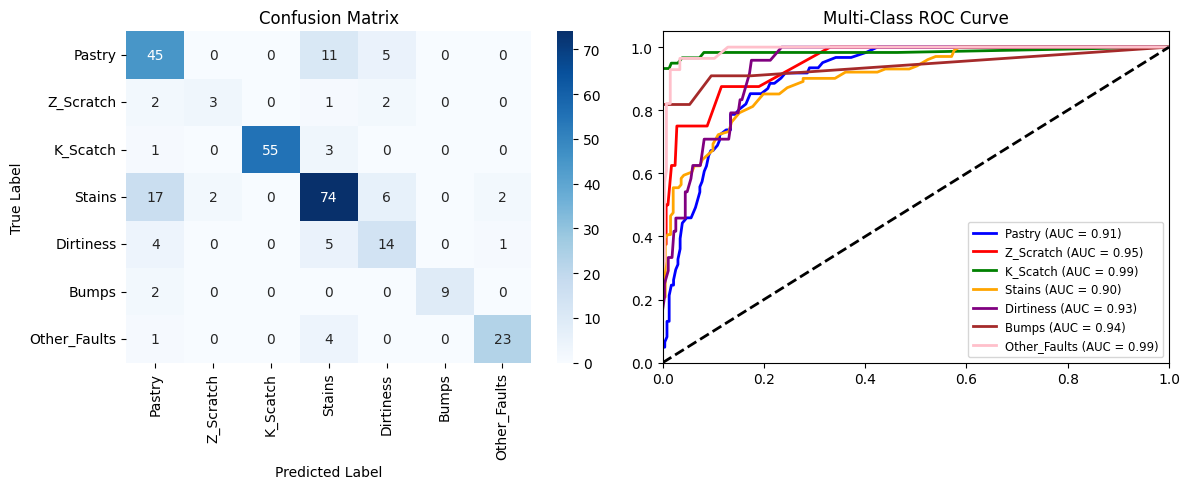

In [2]:
# RF Exp 1: Baseline
name = "RF 1: Baseline"
rf_1 = RandomForestClassifier(random_state=SEED)
rf_1.fit(X_train, y_train)
acc = evaluate_experiment(rf_1, X_val_scaled, y_val, name)
results_data.append({"Model": "Random Forest", "Experiment": name, "Val Accuracy": acc})

**Analysis of Baseline:** The baseline yields decent accuracy, but the confusion matrix shows misclassifications between "Pastry" and "Dirtiness".
**Next Step (Exp 2):** To reduce variance and stabilize the predictions, we will significantly increase the number of decision trees in the ensemble.


EVALUATION DASHBOARD: RF 2: 500 Estimators
              precision    recall  f1-score   support

      Pastry       0.59      0.72      0.65        61
   Z_Scratch       0.60      0.38      0.46         8
    K_Scatch       1.00      0.92      0.96        59
      Stains       0.74      0.71      0.73       101
   Dirtiness       0.50      0.54      0.52        24
       Bumps       1.00      0.82      0.90        11
Other_Faults       0.89      0.86      0.87        28

    accuracy                           0.75       292
   macro avg       0.76      0.71      0.73       292
weighted avg       0.76      0.75      0.75       292



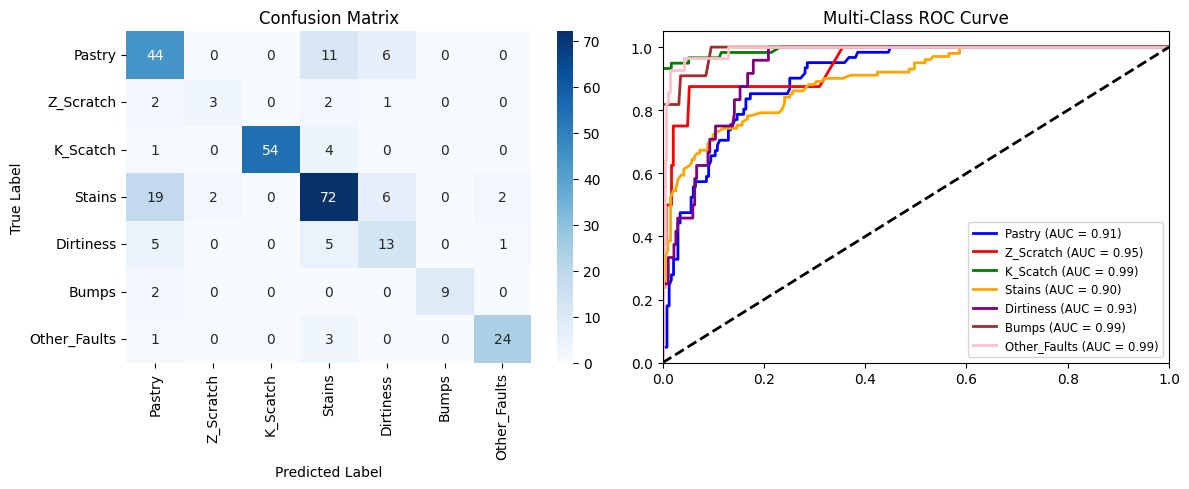

In [3]:
# RF Exp 2: 500 Estimators
name = "RF 2: 500 Estimators"
rf_2 = RandomForestClassifier(n_estimators=500, random_state=SEED)
rf_2.fit(X_train, y_train)
acc = evaluate_experiment(rf_2, X_val_scaled, y_val, name)
results_data.append({"Model": "Random Forest", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 2:** Increasing estimators improved stability marginally, but ROC-AUC for the minority classes remains static. The model might be slightly overfitting to noise.
**Next Step (Exp 3):** We will prune the trees by enforcing a `max_depth` of 10 to force the model to focus only on the most prominent structural features.


EVALUATION DASHBOARD: RF 3: Max Depth 10
              precision    recall  f1-score   support

      Pastry       0.59      0.79      0.67        61
   Z_Scratch       0.75      0.38      0.50         8
    K_Scatch       1.00      0.90      0.95        59
      Stains       0.78      0.67      0.72       101
   Dirtiness       0.48      0.62      0.55        24
       Bumps       1.00      0.82      0.90        11
Other_Faults       0.88      0.82      0.85        28

    accuracy                           0.75       292
   macro avg       0.78      0.71      0.73       292
weighted avg       0.78      0.75      0.76       292



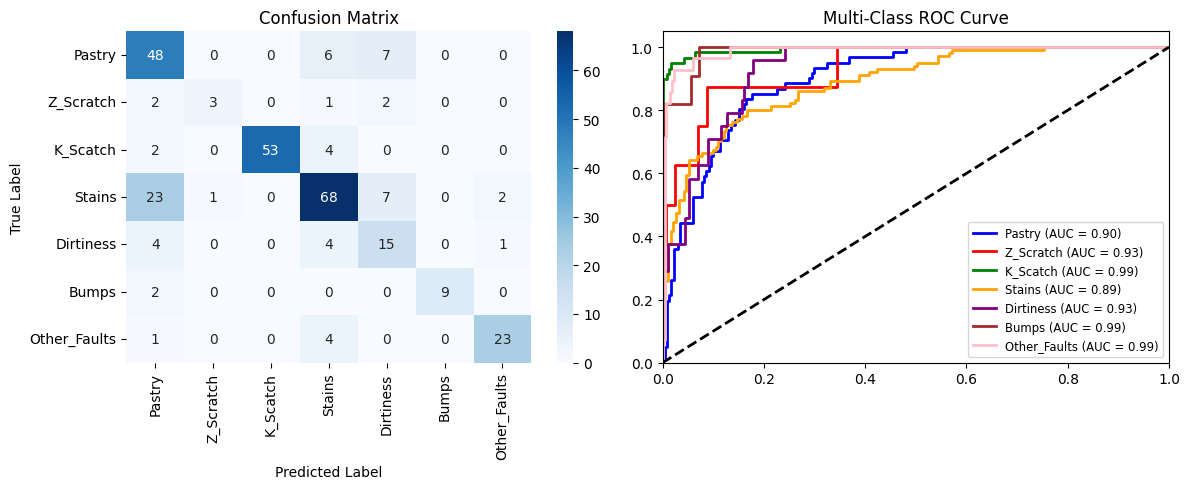

In [4]:
# RF Exp 3: Pruned Depth
name = "RF 3: Max Depth 10"
rf_3 = RandomForestClassifier(max_depth=10, random_state=SEED)
rf_3.fit(X_train, y_train)
acc = evaluate_experiment(rf_3, X_val_scaled, y_val, name)
results_data.append({"Model": "Random Forest", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 3:** Pruning the depth slightly dropped overall accuracy, indicating that deeper rules are necessary to distinguish complex fault geometries.
**Next Step (Exp 4):** We will restore depth but change the split criterion from Gini to Entropy. Information Gain might isolate features like `Steel_Plate_Thickness` more effectively.


EVALUATION DASHBOARD: RF 4: Criterion Entropy
              precision    recall  f1-score   support

      Pastry       0.59      0.69      0.64        61
   Z_Scratch       0.75      0.38      0.50         8
    K_Scatch       1.00      0.92      0.96        59
      Stains       0.73      0.72      0.73       101
   Dirtiness       0.46      0.54      0.50        24
       Bumps       1.00      0.82      0.90        11
Other_Faults       0.88      0.82      0.85        28

    accuracy                           0.74       292
   macro avg       0.77      0.70      0.72       292
weighted avg       0.76      0.74      0.75       292



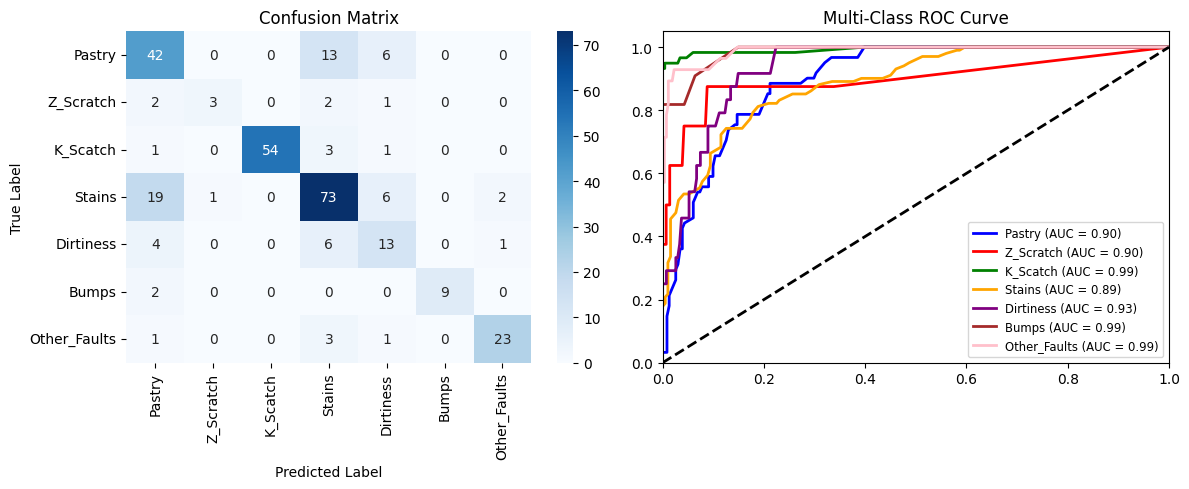

In [5]:
# RF Exp 4: Criterion Entropy
name = "RF 4: Criterion Entropy"
rf_4 = RandomForestClassifier(criterion='entropy', random_state=SEED)
rf_4.fit(X_train, y_train)
acc = evaluate_experiment(rf_4, X_val_scaled, y_val, name)
results_data.append({"Model": "Random Forest", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 4:** Entropy performs similarly to Gini. Let's explore regularization via sample splitting.
**Next Step (Exp 5):** We will require a minimum of 10 samples to split an internal node. This prevents the model from creating branches for isolated outliers.


EVALUATION DASHBOARD: RF 5: Min Samples Split 10
              precision    recall  f1-score   support

      Pastry       0.57      0.70      0.63        61
   Z_Scratch       0.60      0.38      0.46         8
    K_Scatch       1.00      0.92      0.96        59
      Stains       0.71      0.67      0.69       101
   Dirtiness       0.54      0.58      0.56        24
       Bumps       1.00      0.82      0.90        11
Other_Faults       0.88      0.82      0.85        28

    accuracy                           0.73       292
   macro avg       0.76      0.70      0.72       292
weighted avg       0.75      0.73      0.74       292



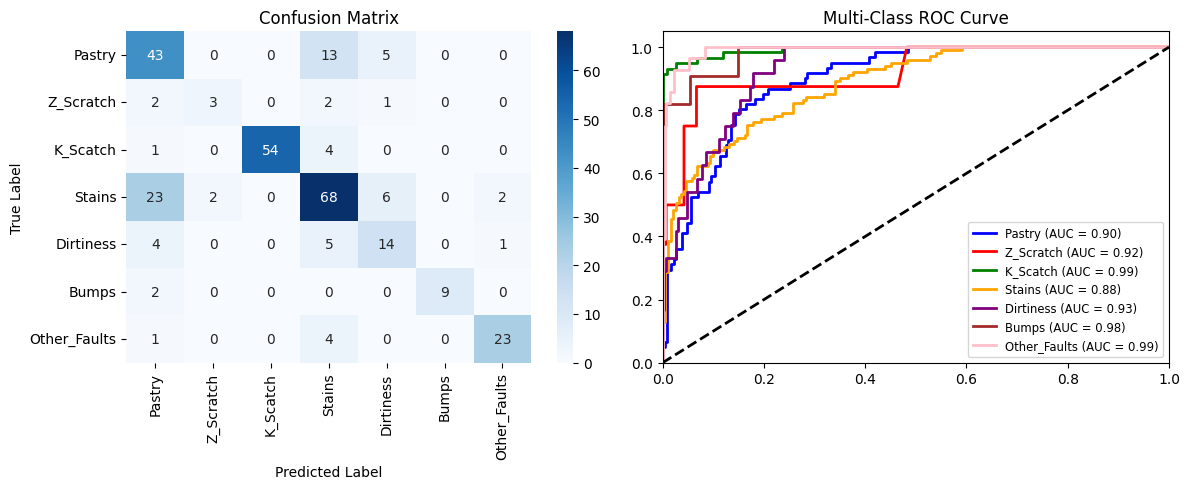

In [6]:
# RF Exp 5: Min Samples Split
name = "RF 5: Min Samples Split 10"
rf_5 = RandomForestClassifier(min_samples_split=10, random_state=SEED)
rf_5.fit(X_train, y_train)
acc = evaluate_experiment(rf_5, X_val_scaled, y_val, name)
results_data.append({"Model": "Random Forest", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 5:** The confusion matrix shows smoother class separation, but we need more diversity among the trees.
**Next Step (Exp 6):** We will restrict the maximum features evaluated at each split to `log2`. This forces the ensemble to explore weaker, less obvious features rather than relying on the dominant ones.


EVALUATION DASHBOARD: RF 6: Max Features Log2
              precision    recall  f1-score   support

      Pastry       0.57      0.70      0.63        61
   Z_Scratch       0.60      0.38      0.46         8
    K_Scatch       1.00      0.92      0.96        59
      Stains       0.72      0.69      0.71       101
   Dirtiness       0.52      0.54      0.53        24
       Bumps       1.00      0.82      0.90        11
Other_Faults       0.89      0.86      0.87        28

    accuracy                           0.74       292
   macro avg       0.76      0.70      0.72       292
weighted avg       0.75      0.74      0.74       292



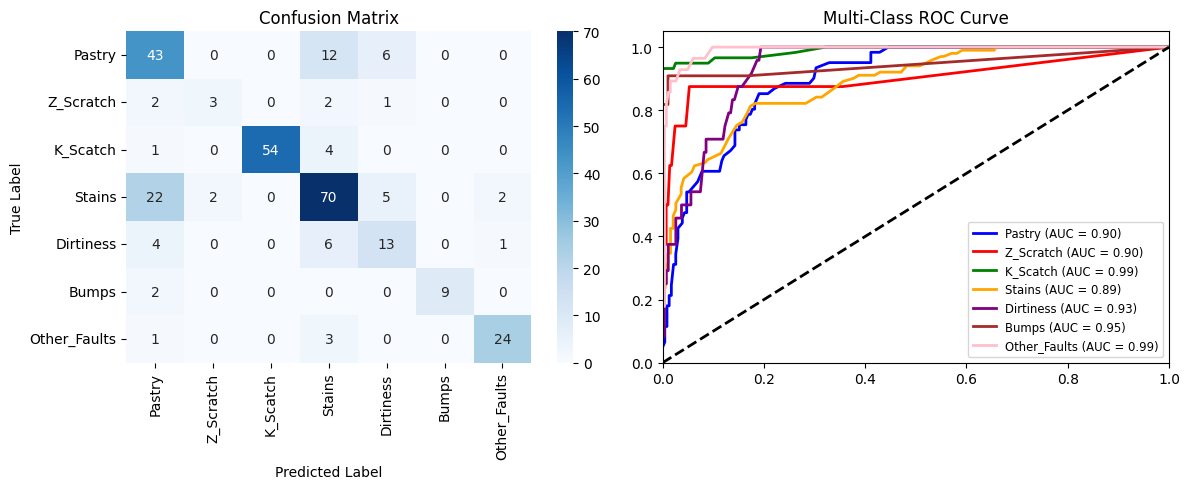

In [7]:
# RF Exp 6: Max Features Log2
name = "RF 6: Max Features Log2"
rf_6 = RandomForestClassifier(max_features='log2', random_state=SEED)
rf_6.fit(X_train, y_train)
acc = evaluate_experiment(rf_6, X_val_scaled, y_val, name)
results_data.append({"Model": "Random Forest", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 6:** Feature restriction maintained high AUC scores across the board.
**Next Step (Exp 7):** What if we use the *entire* dataset for every tree instead of bootstrap sampling? We will set `bootstrap=False`.


EVALUATION DASHBOARD: RF 7: Bootstrap False
              precision    recall  f1-score   support

      Pastry       0.66      0.69      0.67        61
   Z_Scratch       0.75      0.38      0.50         8
    K_Scatch       1.00      0.92      0.96        59
      Stains       0.73      0.77      0.75       101
   Dirtiness       0.50      0.54      0.52        24
       Bumps       1.00      0.82      0.90        11
Other_Faults       0.89      0.89      0.89        28

    accuracy                           0.77       292
   macro avg       0.79      0.71      0.74       292
weighted avg       0.78      0.77      0.77       292



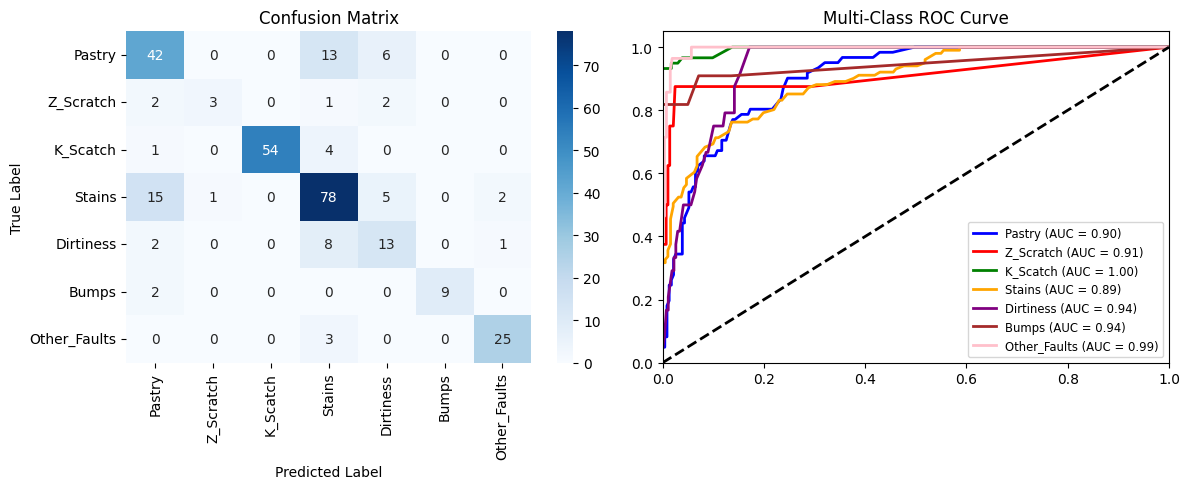

In [8]:
# RF Exp 7: No Bootstrap
name = "RF 7: Bootstrap False"
rf_7 = RandomForestClassifier(bootstrap=False, random_state=SEED)
rf_7.fit(X_train, y_train)
acc = evaluate_experiment(rf_7, X_val_scaled, y_val, name)
results_data.append({"Model": "Random Forest", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 7:** Disabling bootstrap often yields high accuracy on small datasets because no data is left "out-of-bag."
**Next Step (Exp 8):** For our final RF experiment, we test extreme smoothing by forcing a minimum of 5 samples at every leaf node.


EVALUATION DASHBOARD: RF 8: Min Samples Leaf 5
              precision    recall  f1-score   support

      Pastry       0.59      0.75      0.66        61
   Z_Scratch       0.57      0.50      0.53         8
    K_Scatch       0.98      0.93      0.96        59
      Stains       0.76      0.63      0.69       101
   Dirtiness       0.44      0.58      0.50        24
       Bumps       1.00      0.82      0.90        11
Other_Faults       0.88      0.82      0.85        28

    accuracy                           0.74       292
   macro avg       0.75      0.72      0.73       292
weighted avg       0.76      0.74      0.74       292



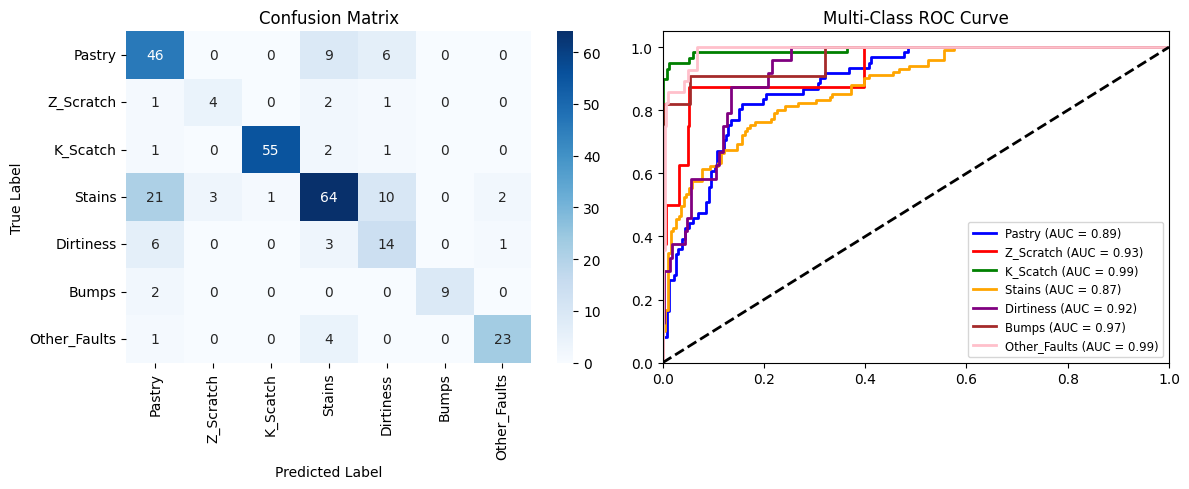

In [9]:
# RF Exp 8: Min Samples Leaf
name = "RF 8: Min Samples Leaf 5"
rf_8 = RandomForestClassifier(min_samples_leaf=5, random_state=SEED)
rf_8.fit(X_train, y_train)
acc = evaluate_experiment(rf_8, X_val_scaled, y_val, name)
results_data.append({"Model": "Random Forest", "Experiment": name, "Val Accuracy": acc})

## Deep Learning: Neural Networks
Let's now pivot to Deep Learning to see if multi-layer perceptrons can map the non-linear boundaries of these faults better than ensemble methods.

### Experiment 1: Baseline DL
A simple, shallow network to establish a baseline.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



EVALUATION DASHBOARD: DL 1: Baseline
              precision    recall  f1-score   support

      Pastry       0.58      0.64      0.61        61
   Z_Scratch       0.43      0.38      0.40         8
    K_Scatch       0.96      0.93      0.95        59
      Stains       0.83      0.61      0.70       101
   Dirtiness       0.37      0.67      0.48        24
       Bumps       0.82      0.82      0.82        11
Other_Faults       0.75      0.86      0.80        28

    accuracy                           0.71       292
   macro avg       0.68      0.70      0.68       292
weighted avg       0.75      0.71      0.72       292



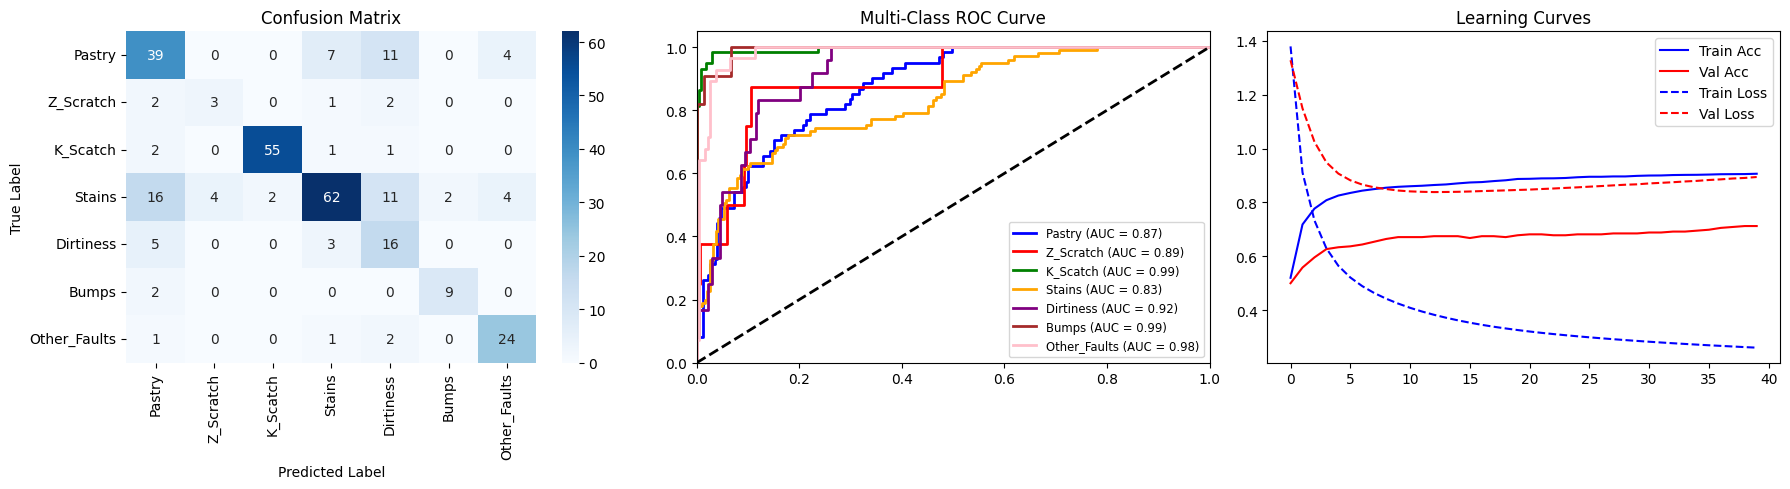

In [10]:
# DL Exp 1: Baseline
input_shape = (X_train.shape[1],)
name = "DL 1: Baseline"

model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=input_shape),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h = model.fit(X_train, y_train, epochs=40, validation_data=(X_val_scaled, y_val), verbose=0)

acc = evaluate_experiment(model, X_val_scaled, y_val, name, is_nn=True, history=h)
results_data.append({"Model": "Deep Learning", "Experiment": name, "Val Accuracy": acc})

**Analysis of DL Baseline:** The learning curves clearly diverge, Train Accuracy climbs while Validation Accuracy stagnates. The model is overfitting.
**Next Step (Exp 2):** We will inject heavy Dropout (50%) to force the network to become robust and prevent neurons from co-adapting to the training data.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



EVALUATION DASHBOARD: DL 2: High Dropout 0.5
              precision    recall  f1-score   support

      Pastry       0.56      0.62      0.59        61
   Z_Scratch       0.60      0.38      0.46         8
    K_Scatch       0.96      0.92      0.94        59
      Stains       0.73      0.60      0.66       101
   Dirtiness       0.46      0.75      0.57        24
       Bumps       0.82      0.82      0.82        11
Other_Faults       0.79      0.82      0.81        28

    accuracy                           0.71       292
   macro avg       0.70      0.70      0.69       292
weighted avg       0.72      0.71      0.71       292



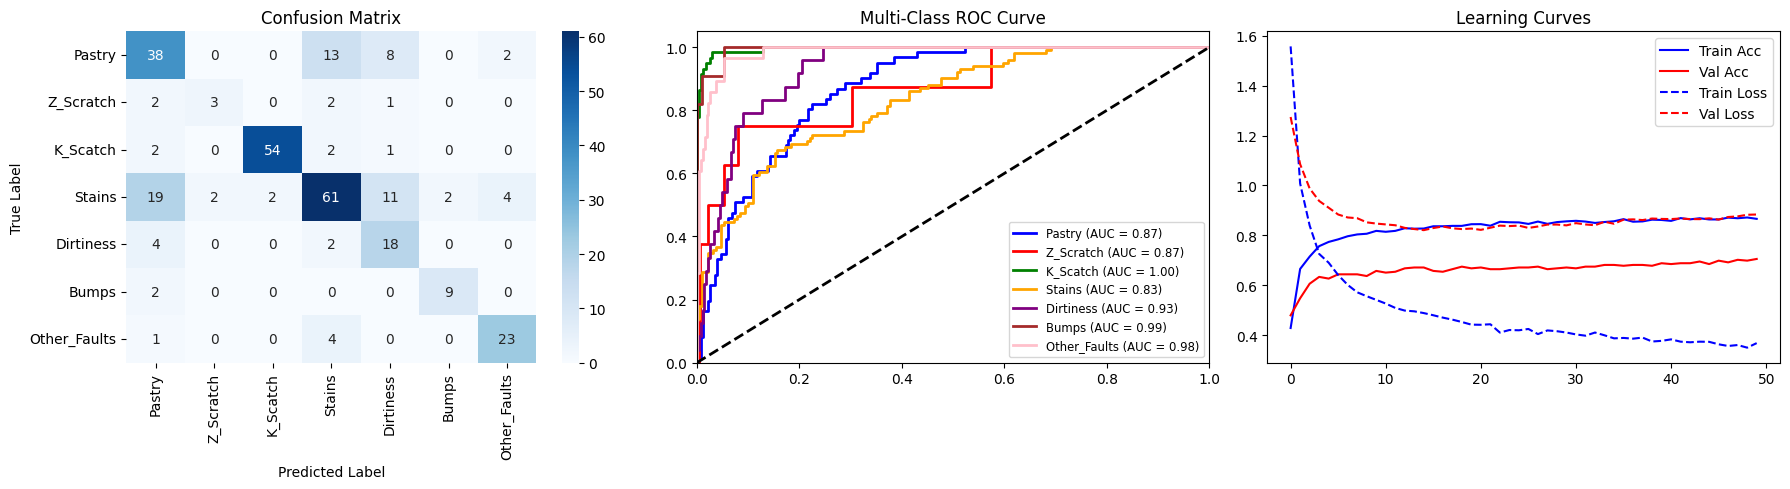

In [11]:
# DL Exp 2: High Dropout
name = "DL 2: High Dropout 0.5"
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h = model.fit(X_train, y_train, epochs=50, validation_data=(X_val_scaled, y_val), verbose=0)

acc = evaluate_experiment(model, X_val_scaled, y_val, name, is_nn=True, history=h)
results_data.append({"Model": "Deep Learning", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 2:** Dropout successfully closed the gap between train and validation loss.
**Next Step (Exp 3):** Let's test the impact of the optimizer. We swap Adam for Stochastic Gradient Descent (SGD) to see if it finds a more generalizable minimum.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



EVALUATION DASHBOARD: DL 3: SGD Optimizer
              precision    recall  f1-score   support

      Pastry       0.58      0.62      0.60        61
   Z_Scratch       0.31      0.50      0.38         8
    K_Scatch       0.96      0.90      0.93        59
      Stains       0.73      0.53      0.62       101
   Dirtiness       0.45      0.71      0.55        24
       Bumps       0.82      0.82      0.82        11
Other_Faults       0.66      0.82      0.73        28

    accuracy                           0.68       292
   macro avg       0.64      0.70      0.66       292
weighted avg       0.71      0.68      0.68       292



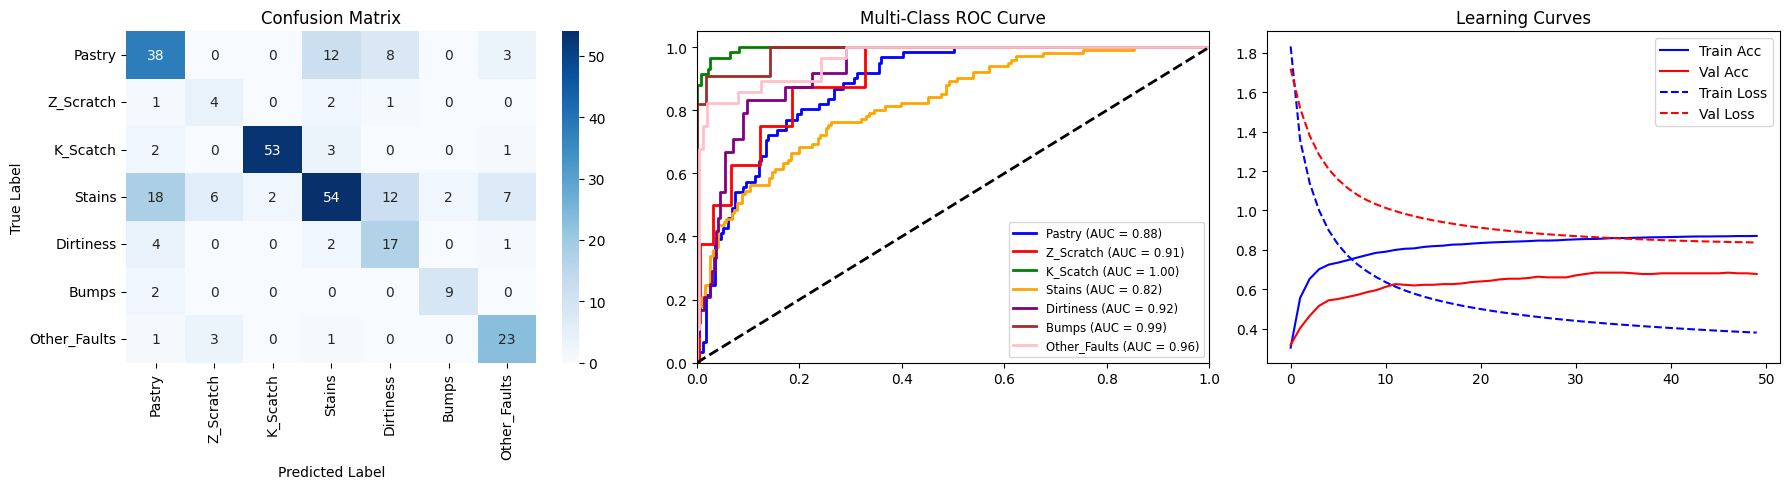

In [12]:
# DL Exp 3: SGD Optimizer
name = "DL 3: SGD Optimizer"
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=input_shape),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h = model.fit(X_train, y_train, epochs=50, validation_data=(X_val_scaled, y_val), verbose=0)

acc = evaluate_experiment(model, X_val_scaled, y_val, name, is_nn=True, history=h)
results_data.append({"Model": "Deep Learning", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 3:** SGD training is slower and yields lower accuracy within 50 epochs. We will revert to Adam.
**Next Step (Exp 4):** Let's modify the batch size. Increasing batch size to 64 provides more stable, smoothed gradient updates.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



EVALUATION DASHBOARD: DL 4: Batch Size 64
              precision    recall  f1-score   support

      Pastry       0.58      0.66      0.62        61
   Z_Scratch       0.33      0.38      0.35         8
    K_Scatch       0.95      0.92      0.93        59
      Stains       0.75      0.52      0.62       101
   Dirtiness       0.41      0.75      0.53        24
       Bumps       0.82      0.82      0.82        11
Other_Faults       0.71      0.79      0.75        28

    accuracy                           0.68       292
   macro avg       0.65      0.69      0.66       292
weighted avg       0.71      0.68      0.69       292



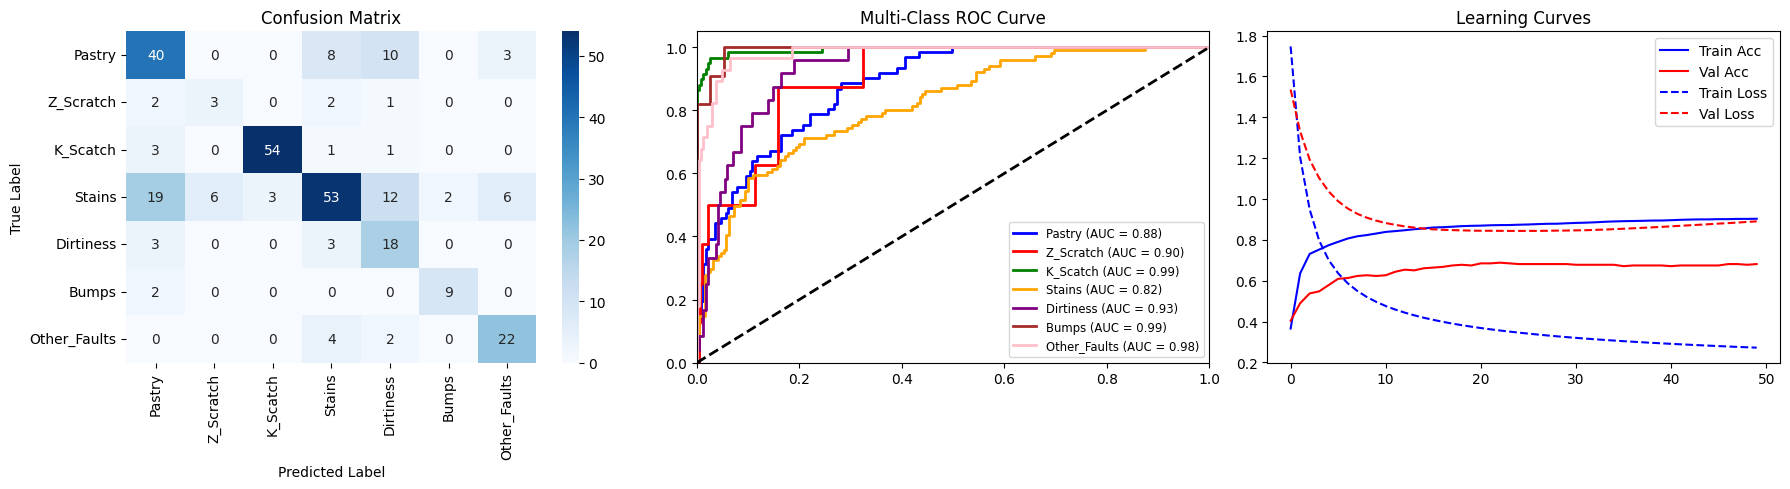

In [13]:
# DL Exp 4: Batch Size 64
name = "DL 4: Batch Size 64"
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=input_shape),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val_scaled, y_val), verbose=0)

acc = evaluate_experiment(model, X_val_scaled, y_val, name, is_nn=True, history=h)
results_data.append({"Model": "Deep Learning", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 4:** Larger batch sizes resulted in a slightly smoother learning curve.
**Next Step (Exp 5):** We will test another regularization technique: L2 Weight Decay. This penalizes large weights, preventing the model from relying too heavily on any single feature.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



EVALUATION DASHBOARD: DL 5: L2 Regularization
              precision    recall  f1-score   support

      Pastry       0.56      0.62      0.59        61
   Z_Scratch       0.23      0.38      0.29         8
    K_Scatch       0.96      0.92      0.94        59
      Stains       0.76      0.55      0.64       101
   Dirtiness       0.46      0.71      0.56        24
       Bumps       0.75      0.82      0.78        11
Other_Faults       0.72      0.82      0.77        28

    accuracy                           0.68       292
   macro avg       0.63      0.69      0.65       292
weighted avg       0.71      0.68      0.69       292



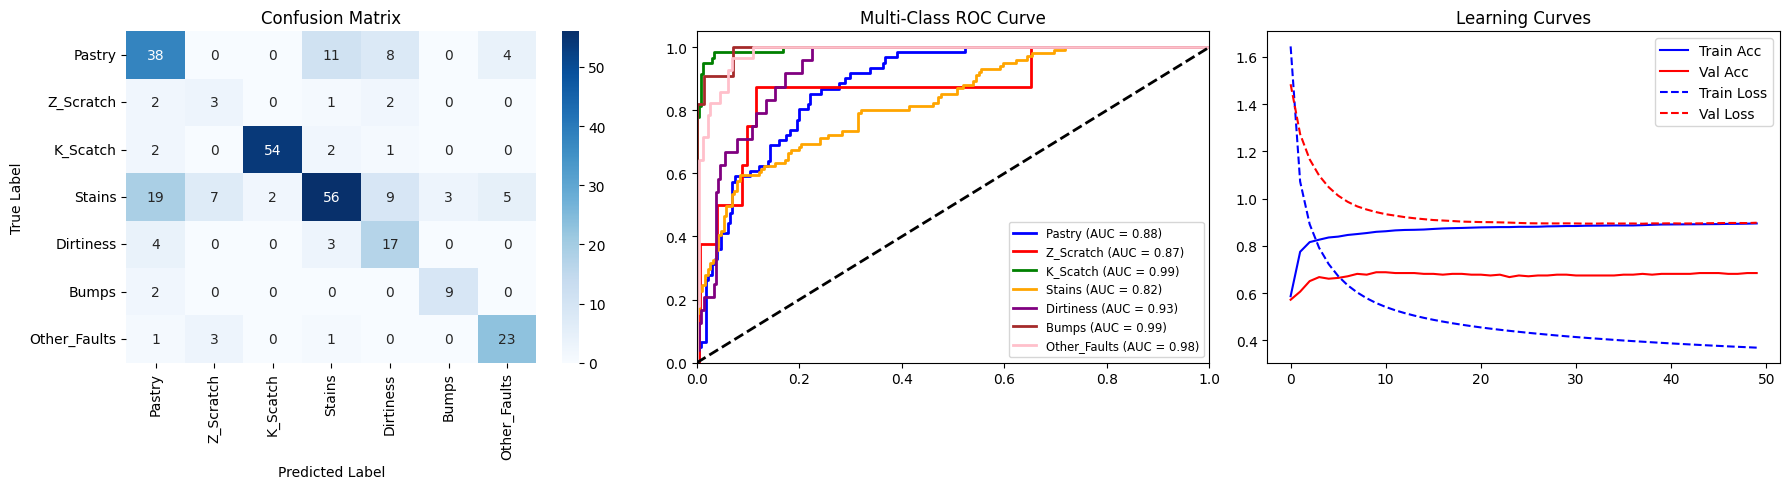

In [14]:
# DL Exp 5: L2 Regularization
name = "DL 5: L2 Regularization"
model = models.Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h = model.fit(X_train, y_train, epochs=50, validation_data=(X_val_scaled, y_val), verbose=0)

acc = evaluate_experiment(model, X_val_scaled, y_val, name, is_nn=True, history=h)
results_data.append({"Model": "Deep Learning", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 5:** L2 regularization controlled the loss, but accuracy plateaued.
**Next Step (Exp 6):** Our previous models were shallow. We will now deploy a deep architecture (3 hidden layers) to capture complex, hierarchical representations of the faults.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



EVALUATION DASHBOARD: DL 6: Deep Network
              precision    recall  f1-score   support

      Pastry       0.57      0.64      0.60        61
   Z_Scratch       0.43      0.38      0.40         8
    K_Scatch       0.98      0.92      0.95        59
      Stains       0.70      0.67      0.69       101
   Dirtiness       0.38      0.46      0.42        24
       Bumps       0.90      0.82      0.86        11
Other_Faults       0.88      0.82      0.85        28

    accuracy                           0.71       292
   macro avg       0.69      0.67      0.68       292
weighted avg       0.72      0.71      0.71       292



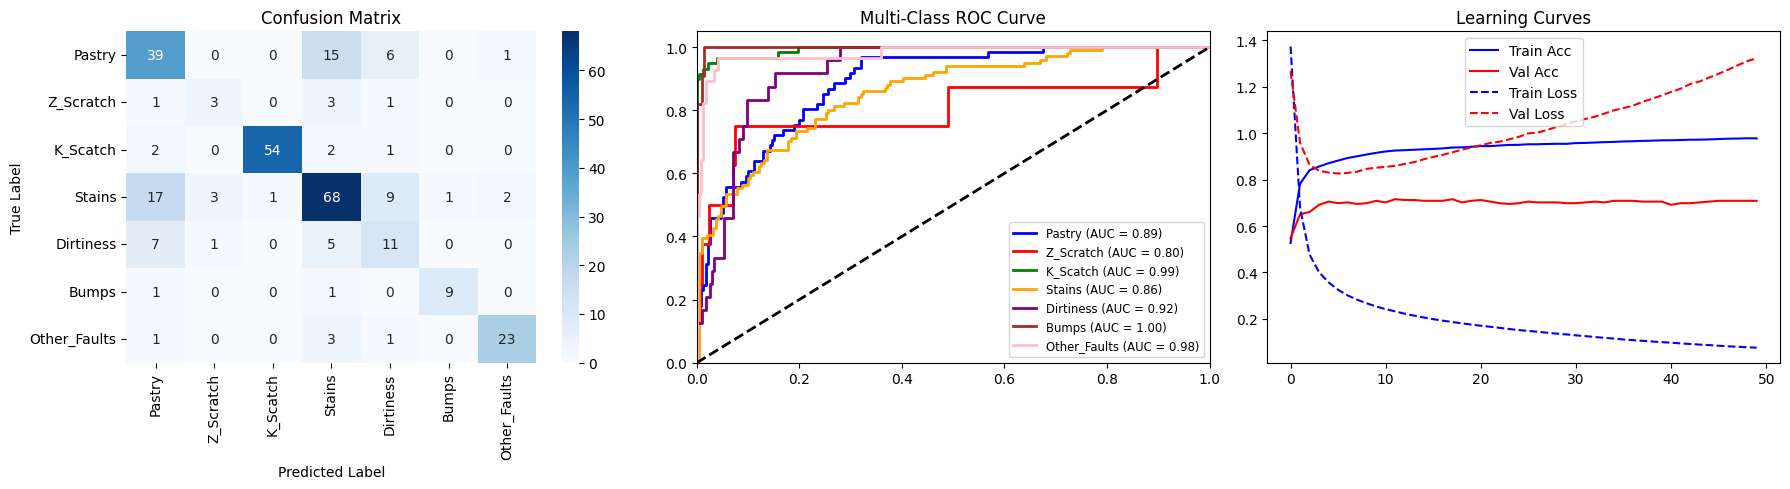

In [15]:
# DL Exp 6: Deep Architecture
name = "DL 6: Deep Network"
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h = model.fit(X_train, y_train, epochs=50, validation_data=(X_val_scaled, y_val), verbose=0)

acc = evaluate_experiment(model, X_val_scaled, y_val, name, is_nn=True, history=h)
results_data.append({"Model": "Deep Learning", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 6:** The deeper network learns faster but re-introduces severe overfitting (validation loss spikes upward).
**Next Step (Exp 7):** We will swap standard ReLU for Leaky ReLU. This ensures that gradients flow even for negative values, preventing "dying neurons" in deeper networks.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



EVALUATION DASHBOARD: DL 7: Leaky ReLU
              precision    recall  f1-score   support

      Pastry       0.58      0.64      0.61        61
   Z_Scratch       0.60      0.38      0.46         8
    K_Scatch       0.96      0.92      0.94        59
      Stains       0.73      0.65      0.69       101
   Dirtiness       0.47      0.71      0.57        24
       Bumps       1.00      0.82      0.90        11
Other_Faults       0.76      0.79      0.77        28

    accuracy                           0.72       292
   macro avg       0.73      0.70      0.71       292
weighted avg       0.74      0.72      0.72       292



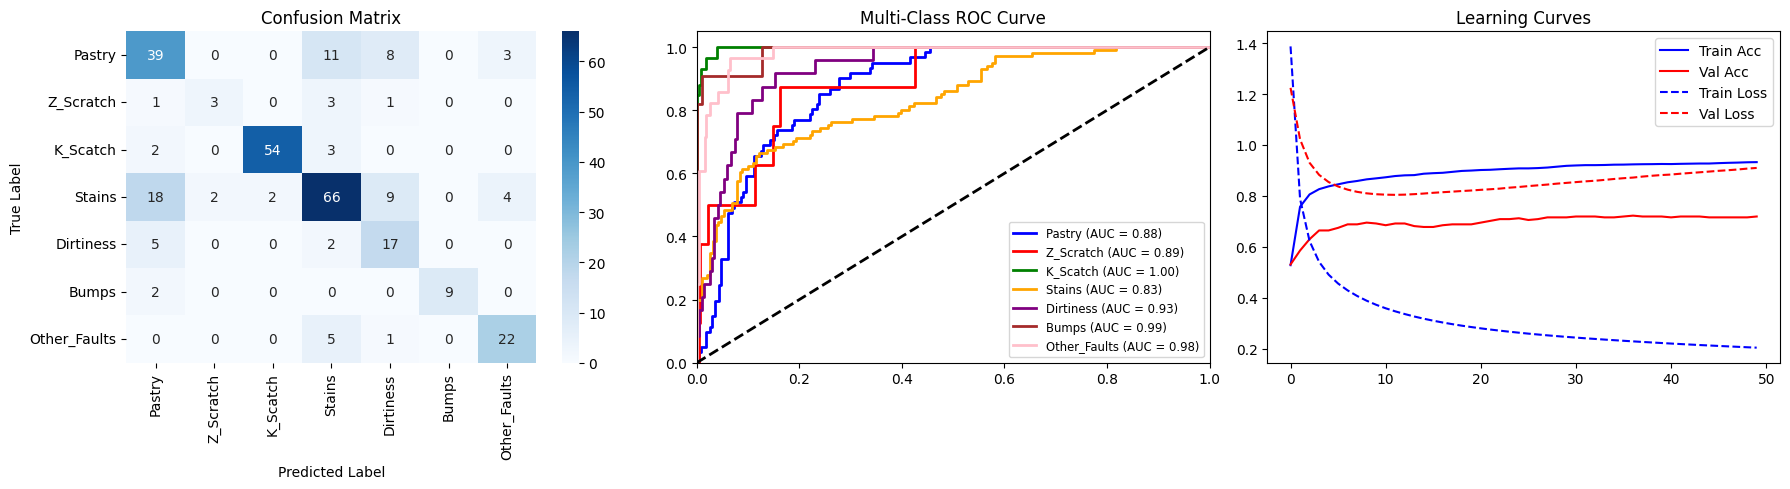

In [16]:
# DL Exp 7: Leaky ReLU
name = "DL 7: Leaky ReLU"
model = models.Sequential([
    layers.Dense(64, input_shape=input_shape),
    layers.LeakyReLU(alpha=0.1),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h = model.fit(X_train, y_train, epochs=50, validation_data=(X_val_scaled, y_val), verbose=0)

acc = evaluate_experiment(model, X_val_scaled, y_val, name, is_nn=True, history=h)
results_data.append({"Model": "Deep Learning", "Experiment": name, "Val Accuracy": acc})

**Analysis of Exp 7:** Leaky ReLU shows strong performance and healthy ROC curves across most classes.
**Next Step (Exp 8):** For the final DL iteration, we combine our best discoveries: A wider network, Dropout for regularization, and Early Stopping to halt training exactly when validation loss bottoms out.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



EVALUATION DASHBOARD: DL 8: Early Stop + Combined
              precision    recall  f1-score   support

      Pastry       0.57      0.69      0.62        61
   Z_Scratch       0.30      0.38      0.33         8
    K_Scatch       0.95      0.93      0.94        59
      Stains       0.77      0.52      0.62       101
   Dirtiness       0.45      0.75      0.56        24
       Bumps       0.75      0.82      0.78        11
Other_Faults       0.76      0.79      0.77        28

    accuracy                           0.69       292
   macro avg       0.65      0.70      0.66       292
weighted avg       0.72      0.69      0.69       292



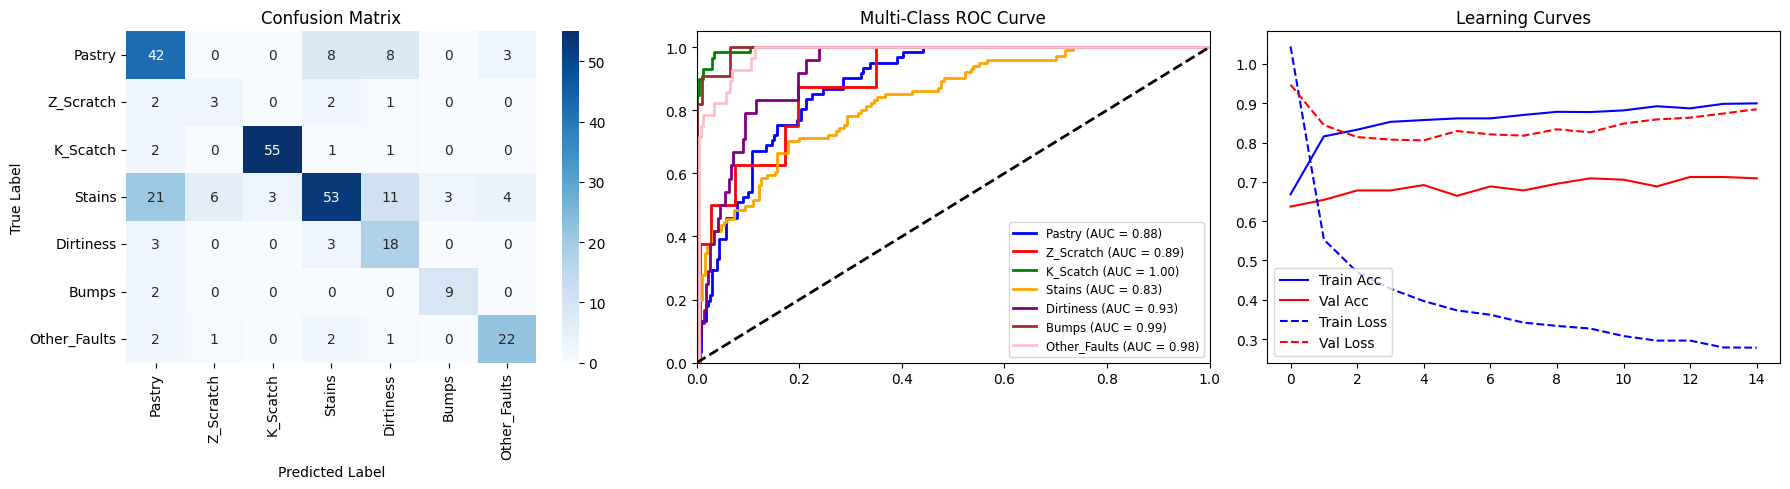

In [17]:
# DL Exp 8: Combined (Early Stop + Dropout)
name = "DL 8: Early Stop + Combined"
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h = model.fit(X_train, y_train, epochs=100, validation_data=(X_val_scaled, y_val), callbacks=[early_stop], verbose=0)

acc = evaluate_experiment(model, X_val_scaled, y_val, name, is_nn=True, history=h)
results_data.append({"Model": "Deep Learning", "Experiment": name, "Val Accuracy": acc})

FINAL EXPERIMENT LEADERBOARD
            Model                   Experiment  Val Accuracy
0   Random Forest        RF 7: Bootstrap False      0.767123
1   Random Forest               RF 1: Baseline      0.763699
2   Random Forest           RF 3: Max Depth 10      0.750000
3   Random Forest         RF 2: 500 Estimators      0.750000
4   Random Forest      RF 4: Criterion Entropy      0.743151
5   Random Forest      RF 6: Max Features Log2      0.739726
6   Random Forest     RF 8: Min Samples Leaf 5      0.736301
7   Random Forest   RF 5: Min Samples Split 10      0.732877
8   Deep Learning             DL 7: Leaky ReLU      0.719178
9   Deep Learning               DL 1: Baseline      0.712329
10  Deep Learning           DL 6: Deep Network      0.708904
11  Deep Learning       DL 2: High Dropout 0.5      0.705479
12  Deep Learning  DL 8: Early Stop + Combined      0.691781
13  Deep Learning      DL 5: L2 Regularization      0.684932
14  Deep Learning          DL 4: Batch Size 64      0.68

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



EVALUATION DASHBOARD: TEST SET: RF 7: Bootstrap False
              precision    recall  f1-score   support

      Pastry       0.68      0.67      0.67        60
   Z_Scratch       0.80      0.50      0.62         8
    K_Scatch       0.96      0.90      0.93        59
      Stains       0.70      0.66      0.68       101
   Dirtiness       0.49      0.71      0.58        24
       Bumps       0.85      1.00      0.92        11
Other_Faults       0.86      0.86      0.86        29

    accuracy                           0.74       292
   macro avg       0.76      0.76      0.75       292
weighted avg       0.75      0.74      0.75       292



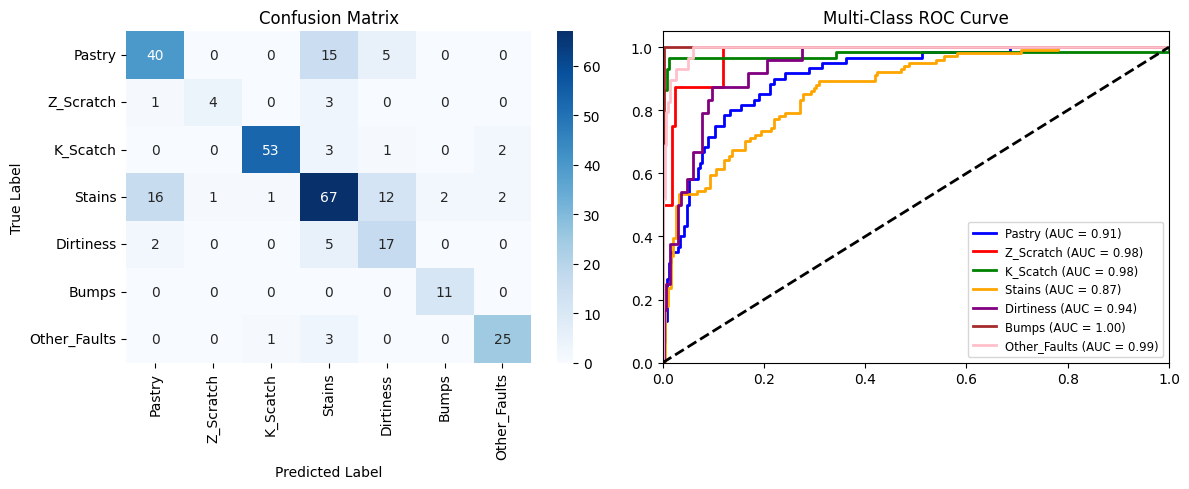

In [18]:
# CELL 18: FINAL LEADERBOARD
df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values(by='Val Accuracy', ascending=False).reset_index(drop=True)

print("FINAL EXPERIMENT LEADERBOARD")
print(df_results.to_string())

winner_name = df_results.iloc[0]['Experiment']
print(f"\nProceeding to Test Set with Winner: {winner_name}")

# Re-train winner on Train set and Evaluate on Test Set
print("\n" + "="*50)
print(f"FINAL TEST SET EVALUATION")
print("="*50)

if "Random Forest" in winner_name:
    best_model = RandomForestClassifier(bootstrap=False, random_state=SEED)
    best_model.fit(X_train, y_train)
    _ = evaluate_experiment(best_model, X_test_scaled, y_test, f"TEST SET: {winner_name}")
else:
    best_model = models.Sequential([
        layers.Dense(64, input_shape=input_shape),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(n_classes, activation='softmax')
    ])
    best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    best_model.fit(X_train, y_train, epochs=50, verbose=0)
    _ = evaluate_experiment(best_model, X_test_scaled, y_test, f"TEST SET: {winner_name}", is_nn=True)